#Initialization / Client Creation

In [11]:
# install API wrapper first
!pip install onboard.client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 4.2 MB/s 
     |████████████████████████████████| 249 kB 13.8 MB/s 


In [12]:
import pandas as pd
from onboard.client import RtemClient

from datetime import datetime, timezone, timedelta
import pytz
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

import warnings
warnings.simplefilter("ignore", UserWarning)

from threading import Event
import random

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (30,15)

In [13]:
api_key = ###Enter your own API Key

In [14]:
client = RtemClient(api_key=api_key)

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')
repos_path = "/content/gdrive/MyDrive"

Mounted at /content/gdrive


In [16]:
metadata = pd.read_csv(os.path.join(repos_path , ###Enter the Address to your Metadata File))

#Functions

In [62]:
def info_desk (metadata):
  bdgs = pd.json_normalize(client.get_all_buildings())
  df_bdgs = pd.DataFrame(bdgs)
  print("Number of Buildings: " +str(len(df_bdgs.index)) + "\n" + "Number of Points: "+ str(len(metadata.index) ) )
  print("Number of Point Types: " + str(len(metadata.point_type.unique()) ) )
  print("\n")
  print("Most occuring point types and their counts: " + "\n" + metadata.point_type.value_counts()[0:7].to_string() )
  print("\n")
  print("Building types and their counts available in the dataset:")
  print(df_bdgs["info.customerType"].value_counts().to_string())
  print("\n")
  print("Which type of building do you want to analyze?")
  bdg_type = input()
  bdgs_selected = df_bdgs[df_bdgs["info.customerType"] == bdg_type ]
  print("\n")
  print( "OK")
  print( "That building type represents "  +  str(len(metadata[metadata.building_id.isin(bdgs_selected.id)].index)) + " points of the total " +  str(len(metadata.index) ) + " points in the data ")
  return bdgs_selected

In [63]:
def more_info(metadata , bdgs_selected):
  a = len(metadata[(metadata.building_id.isin(bdgs_selected.id))].point_type.unique())
  c = metadata[(metadata.building_id.isin(bdgs_selected.id))].point_type.value_counts()
  print("Top 20 Sensor Types out of the total " + str(a) + " in " +str(bdgs_selected["info.customerType"].iloc[0]) + " buildings" + "\n" +"\n" )
  print(c[:20].to_string() + "\n" )
  print("\n" +"Would you like to see the full list of  available sensor types? (y/n)")
  answer = input()
  if answer == "y":
    print(c.to_string())
  else:
    pass

In [64]:
def dict_builder(metadata, bdgs_selected):
  print ("\n" + "Which type of sensors do you want to study in " + str(bdgs_selected["info.customerType"].iloc[0]) + " buildings ?")
  sensor_selected = input()
  metadata_bdgs = metadata[(metadata.building_id.isin(bdgs_selected.id))]
  selection = metadata_bdgs[metadata_bdgs.point_type == sensor_selected ].building_id.value_counts()
  print("\n")
  print("OK! Building dictionary. This might take a while....")
  dict_data = {}


  for i in tqdm(selection.index):
    metadata_selection = metadata_bdgs[metadata_bdgs.point_type == sensor_selected ][metadata_bdgs.building_id == i]
    start = metadata_selection.first_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).min()
    end = metadata_selection.last_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).max()
    points = list(metadata_selection.point_id)
    tz = pytz.timezone('UTC')
    start = datetime(start.year,start.month,start.day,start.hour,start.minute,0).replace(tzinfo=tz)
    end = datetime(end.year,end.month,end.day,end.hour,end.minute,0).replace(tzinfo=tz)

    if start < end:
      timeseries_query = TimeseriesQuery(point_ids = points, start = start, end = end)
      query_results = client.stream_point_timeseries(timeseries_query)
      data = points_df_from_streaming_timeseries(query_results)
      if len(data.index) > 0:
        data["timestamp"] = pd.to_datetime(data['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
      #data.to_csv("/content/gdrive/MyDrive/rtem/temperature time series/rtem_building" + str(i) + "_withsensor.csv", index=False)
        dict_data[str(i)] = data
      del start
      del end
      del metadata_selection
      del points
      del timeseries_query
      del query_results
  
  if ("Consumption" in sensor_type) | ("Flow" in sensor_type):
    propertytype = "intensive"
  else:
    propertytype = "extensive"

  
  return dict_data , propertytype

For some combos such as Speed in Healthcare units, this code breaks because of a error in incomplete reading of data which i believe is the fault of API

In [65]:
def df_builder (metadata , dict_data, propertytype):
  start_list = []
  end_list = []
  for building in dict_data.keys():
    start_list.append( dict_data[building].timestamp.min()  )
    end_list.append( dict_data[building].timestamp.max()  )

  start = min(start_list)
  end = max(end_list)

  idx = pd.date_range(start, end, freq = "5T")
  df = pd.DataFrame()
  df.index = idx
  df.index.name = "timestamp"
  df["placeholder"] = np.zeros
  print("What frequency do you want for recorded data?")
  freq_user = input()

  for building in tqdm(dict_data.keys()):
    data =dict_data[building]
    data["timestamp"] = pd.to_datetime(data['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
    #data.iloc[: , 1::] = ((data.iloc[: , 1::] - 32) * 5 * (1/9))
    if propertytype == "intensive" :
      data = data.resample("5T", on="timestamp").mean()
    elif propertytype == "extensive":
      data = data.resample("5T" , on="timestamp").sum()
    df = pd.merge( df , data , how = "left" , left_on = "timestamp" , right_on = "timestamp")
    del data
    
  df = df.drop(columns = "placeholder")
  df = df.resample(freq_user).mean()
  print("\n")

  if propertytype == "intensive" :
    if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
      df = df.resample("15T").mean()
      if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
        df = df.resample("30T").mean()
        if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
          df = df.resample("H").mean()
          if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
            df = df.resample("2H").mean()
            print("Data Frequency Changed to: 2H ")
          else:
            print("Data Frequency Changed to: H ")
        else:
          print("Data Frequency Changed to: 30T" )
      else:
        print("Data Frequency Changed to: 15T")


  elif propertytype == "extensive" :
    if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
      df = df.resample("15T").sum()
      if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
        df = df.resample("30T").sum()
        if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
          df = df.resample("H").sum()
          if (len(df.index) > 150000)  or  (( df.isna().sum().sum() / df.size ) > 0.95):
            df = df.resample("2H").sum()
            print("Data Frequency Changed to: 2H ")
          else:
            print("Data Frequency Changed to: H ")
        else:
          print("Data Frequency Changed to: 30T" )
      else:
        print("Data Frequency Changed to: 15T")

  startendtimes = pd.DataFrame()
  startendtimes.index = df.columns
  print("\n")
  for sensor in tqdm(df.columns):
    startendtimes.loc[sensor, "startDate"] = df[sensor].first_valid_index()
    startendtimes.loc[sensor, "endDate"] = df[sensor].last_valid_index()

  startendtimes.index.name = "point_id"

  return df , startendtimes

for carbon dioxide measurements the units are ppm whihc are intensive and should be taken average of for resampling

as for output, it is given in terms of percentage which means it is also intensive

In [66]:
def nan_detector (df, startendtimes , max_nan = 0.99):
  date = df.index
  filtered_list = []

  for sensor in tqdm(df.columns):
    df_sensor = df[sensor].truncate(before=startendtimes.T[sensor]["startDate"] , after = startendtimes.T[sensor]["endDate"])
  
    if (df_sensor.isna().sum() > max_nan*len(df_sensor.index)):
      #df.drop(columns = sensor)
      filtered_list.append(sensor)

  return df , filtered_list

In [67]:
def constant_detector (df , startendtimes ,max_constant = 0.99 ):
  constant_list = []
  for sensor in tqdm(df.columns):
    ee = pd.DataFrame()
    ee = df[sensor].truncate(before=startendtimes.T[sensor]["startDate"] , after=startendtimes.T[sensor]["endDate"]).diff()
    ee = ee.dropna()
    if len(ee.index) == 0:
      constant_list.append(sensor)
    else:
      share_constant = len(ee[ee==0]) / len(ee.index)

      if (share_constant > max_constant ) :
        constant_list.append(sensor)

  #df = df.drop(columns = constant_list)
  return df , constant_list

In [68]:
def negligible_detector (df , startendtimes , min_days = 1):
  negligible_list = []
  for sensor in tqdm(df.columns):
    sensor_data = df[sensor].truncate(before = startendtimes.T[sensor]["startDate"] , after = startendtimes.T[sensor]["endDate"])
    if len(sensor_data.index) < ( min_days * 24 ):
      negligible_list.append(sensor)
  #df = df.drop(columns = negligible_list)
  return df , negligible_list

In [69]:
def outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5):
  q1 = np.nanpercentile(df, 25)
  q3 = np.nanpercentile(df, 75)
  IQR = q3-q1
  lwr_bound = q1-(lwr_parameter*IQR)
  upr_bound = q3+(upr_parameter*IQR)
  print("\n" + "Upper Bound: " + str(upr_bound) +"\n" + "Lower Bound: " + str(lwr_bound) + "\n")

  df_outlier_up = df[df>upr_bound]
  df_outlier_down = df[df<lwr_bound]
  outlier_list = []

  for sensor in tqdm(df.columns):
    tot = len(df[sensor].truncate(before = startendtimes.T[sensor]["startDate"] , after = startendtimes.T[sensor]["endDate"]).index)
    up = len(df_outlier_up[sensor].dropna().index)
    down = len(df_outlier_down[sensor].dropna().index)

    share = (up + down) / tot
  
    if share > min_outlier :
      outlier_list.append(sensor)
  df.columns = df.columns.map(str)  
  return df , outlier_list

In [70]:
def show_results(df ,startendtimes, filtered_list , constant_list , negligible_list , outlier_list):
  filtered_df = pd.DataFrame(filtered_list , columns = ["point"])
  filtered_df["reason"] = "Extreme NAN Data"
  constant_df = pd.DataFrame(constant_list , columns = ["point"])
  constant_df["reason"] = "Extreme Constant Data"
  negligible_df = pd.DataFrame(negligible_list , columns = ["point"])
  negligible_df["reason"] = "Extreme Lack of Data"
  outlier_df = pd.DataFrame(outlier_list , columns = ["point"])
  outlier_df["reason"] = "Outlying Data"
  df_final = pd.concat([outlier_df , negligible_df , constant_df, filtered_df], axis=0)
  df_final.index = range(0 , len(df_final.index) , 1)
  df.columns = df.columns.map(str)
  print("\n")
  
  if len(df_final.index) == 0:
    print("No Problematic Sensors!")
  else:
    print("********Problematic Sensors:*********")
    print("\n")
    print(df_final)
    print("\n")
    print("Here are some of the Porblematic Sensors' Plots:" + "\n")
    if len(df_final.index) > 5:
      new_list = random.sample(list(df_final.point), 5)

      for i in (new_list):
        df[str(i)].truncate(before = startendtimes.T[str(i)].startDate , after = startendtimes.T[str(i)].endDate).plot(figsize = (30,5))
        plt.legend()
        i = i+3
        plt.figure()
    elif len(df_final.index) > 0:
      new_list = random.sample(list(df_final.point), 1)

      for i in (new_list):
        df[str(i)].truncate(before = startendtimes.T[str(i)].startDate , after = startendtimes.T[str(i)].endDate).plot(figsize = (30,5))
        plt.legend()
        i = i+3
        plt.figure()

    else:
      pass




  return df_final

#Examples

##Example 1 - Commercial Office x Zone Temperature

Number of Buildings: 229
Number of Points: 44390
Number of Point Types: 246


Most occuring point types and their counts: 
Virtual                      7296
Zone Temperature             5210
Status                       2570
Discharge Air Flow           2522
Command                      1704
Zone Temperature Setpoint    1470
Real Power                   1298


Building types and their counts available in the dataset:
Multifamily           69
Commercial Retail     49
Commercial Office     46
Healthcare            16
Food/Beverage         13
K-12 School            9
College/University     7
Hospitality            7
Not For Profit         5
                       3
Chemicals              1
Manufacturing          1


Which type of building do you want to analyze?
Commercial Office


OK
That building type represents 10361 points of the total 44390 points in the data 
Top 20 Sensor Types out of the total 162 in Commercial Office buildings


Virtual                            1430
Status     

100%|██████████| 20/20 [16:37<00:00, 49.89s/it]


What frequency do you want for recorded data?
15T


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


100%|██████████| 841/841 [02:05<00:00,  6.72it/s]



Upper Bound: 82.17521250000001
Lower Bound: 60.8868725



100%|██████████| 841/841 [02:10<00:00,  6.42it/s]




********Problematic Sensors:*********


      point                 reason
0    343314          Outlying Data
1    343243          Outlying Data
2    343244          Outlying Data
3    343241          Outlying Data
4    343242          Outlying Data
..      ...                    ...
117  414586  Extreme Constant Data
118  198688  Extreme Constant Data
119  198693  Extreme Constant Data
120  208277  Extreme Constant Data
121  208284  Extreme Constant Data

[122 rows x 2 columns]


Here are some of the Porblematic Sensors' Plots:



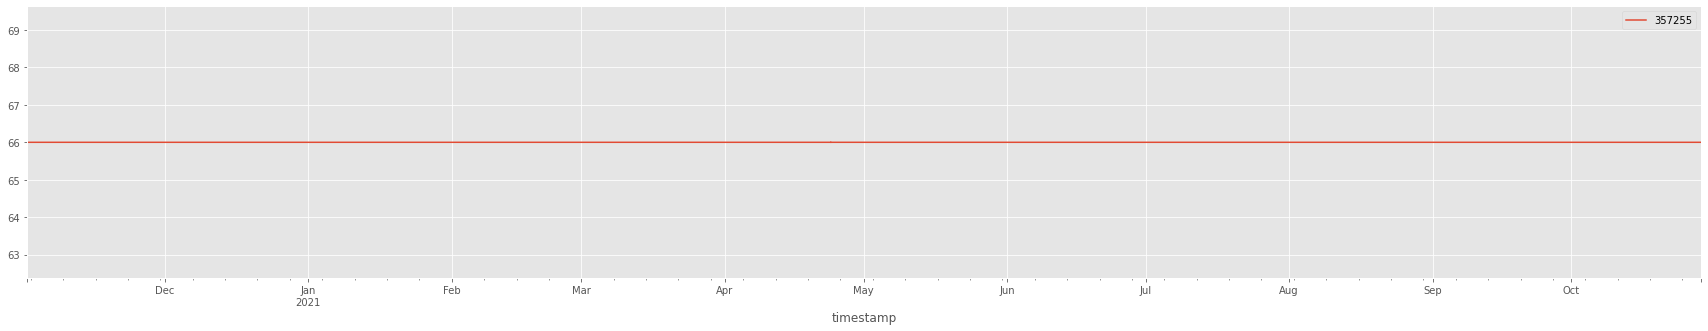

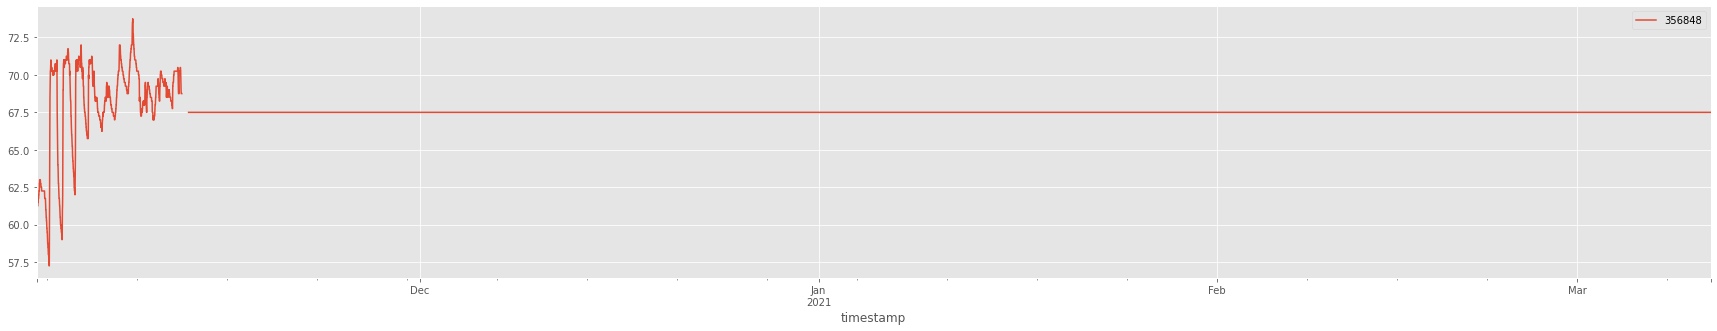

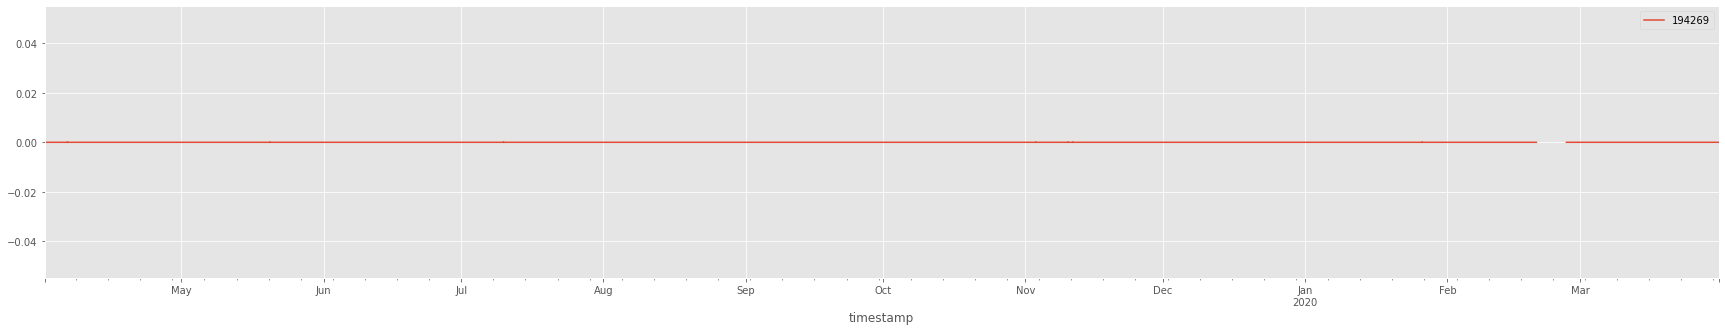

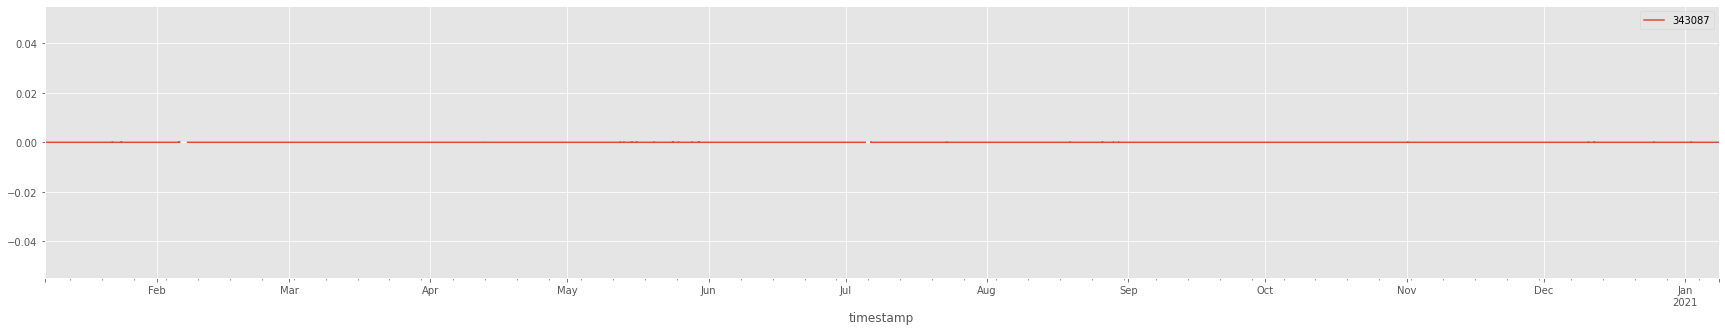

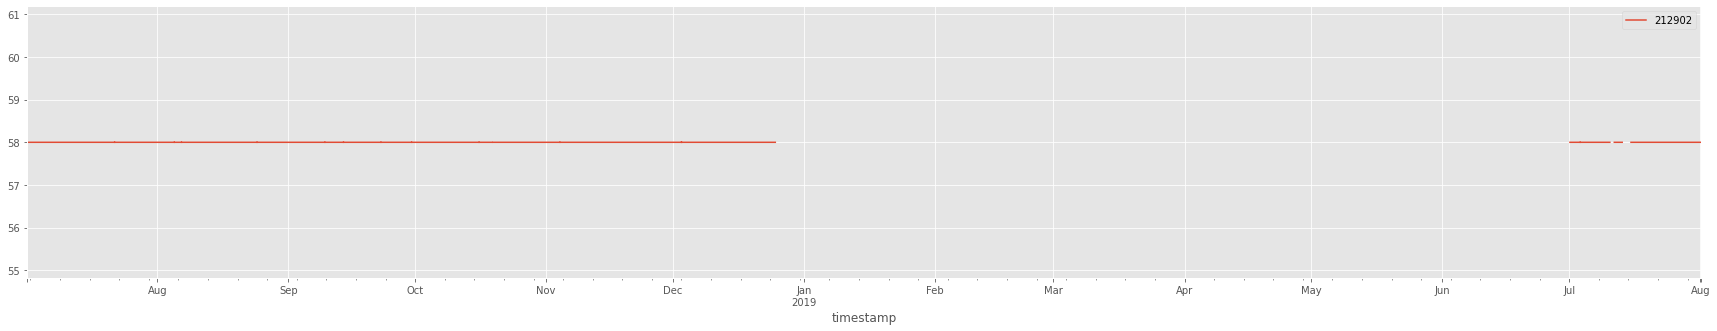

<Figure size 2160x1080 with 0 Axes>

In [ ]:
bdgs_selected = info_desk(metadata)
more_info(metadata , bdgs_selected)
dict_data , propertytype = dict_builder(metadata , bdgs_selected)
df , startendtimes = df_builder (metadata , dict_data, propertytype)
df , filtered_list = nan_detector(df, startendtimes , max_nan = 0.9)
df , constant_list = constant_detector (df , startendtimes ,max_constant = 0.9)
df , negligible_list = negligible_detector (df , startendtimes , min_days = 10)
df , outlier_list = outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5)
df.columns = df.columns.map(str)
startendtimes.index = startendtimes.index.map(str)
df_final = show_results(df , startendtimes, filtered_list , constant_list , negligible_list , outlier_list)

In [ ]:
df_final.loc[35:45 , :]

,point,reason
35,359886,Outlying Data
36,196684,Outlying Data
37,343314,Extreme Constant Data
38,343243,Extreme Constant Data
39,343244,Extreme Constant Data
40,343241,Extreme Constant Data
41,343242,Extreme Constant Data
42,343239,Extreme Constant Data
43,343238,Extreme Constant Data
44,343224,Extreme Constant Data


(array([ 70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.]),
 <a list of 9 Text major ticklabel objects>)

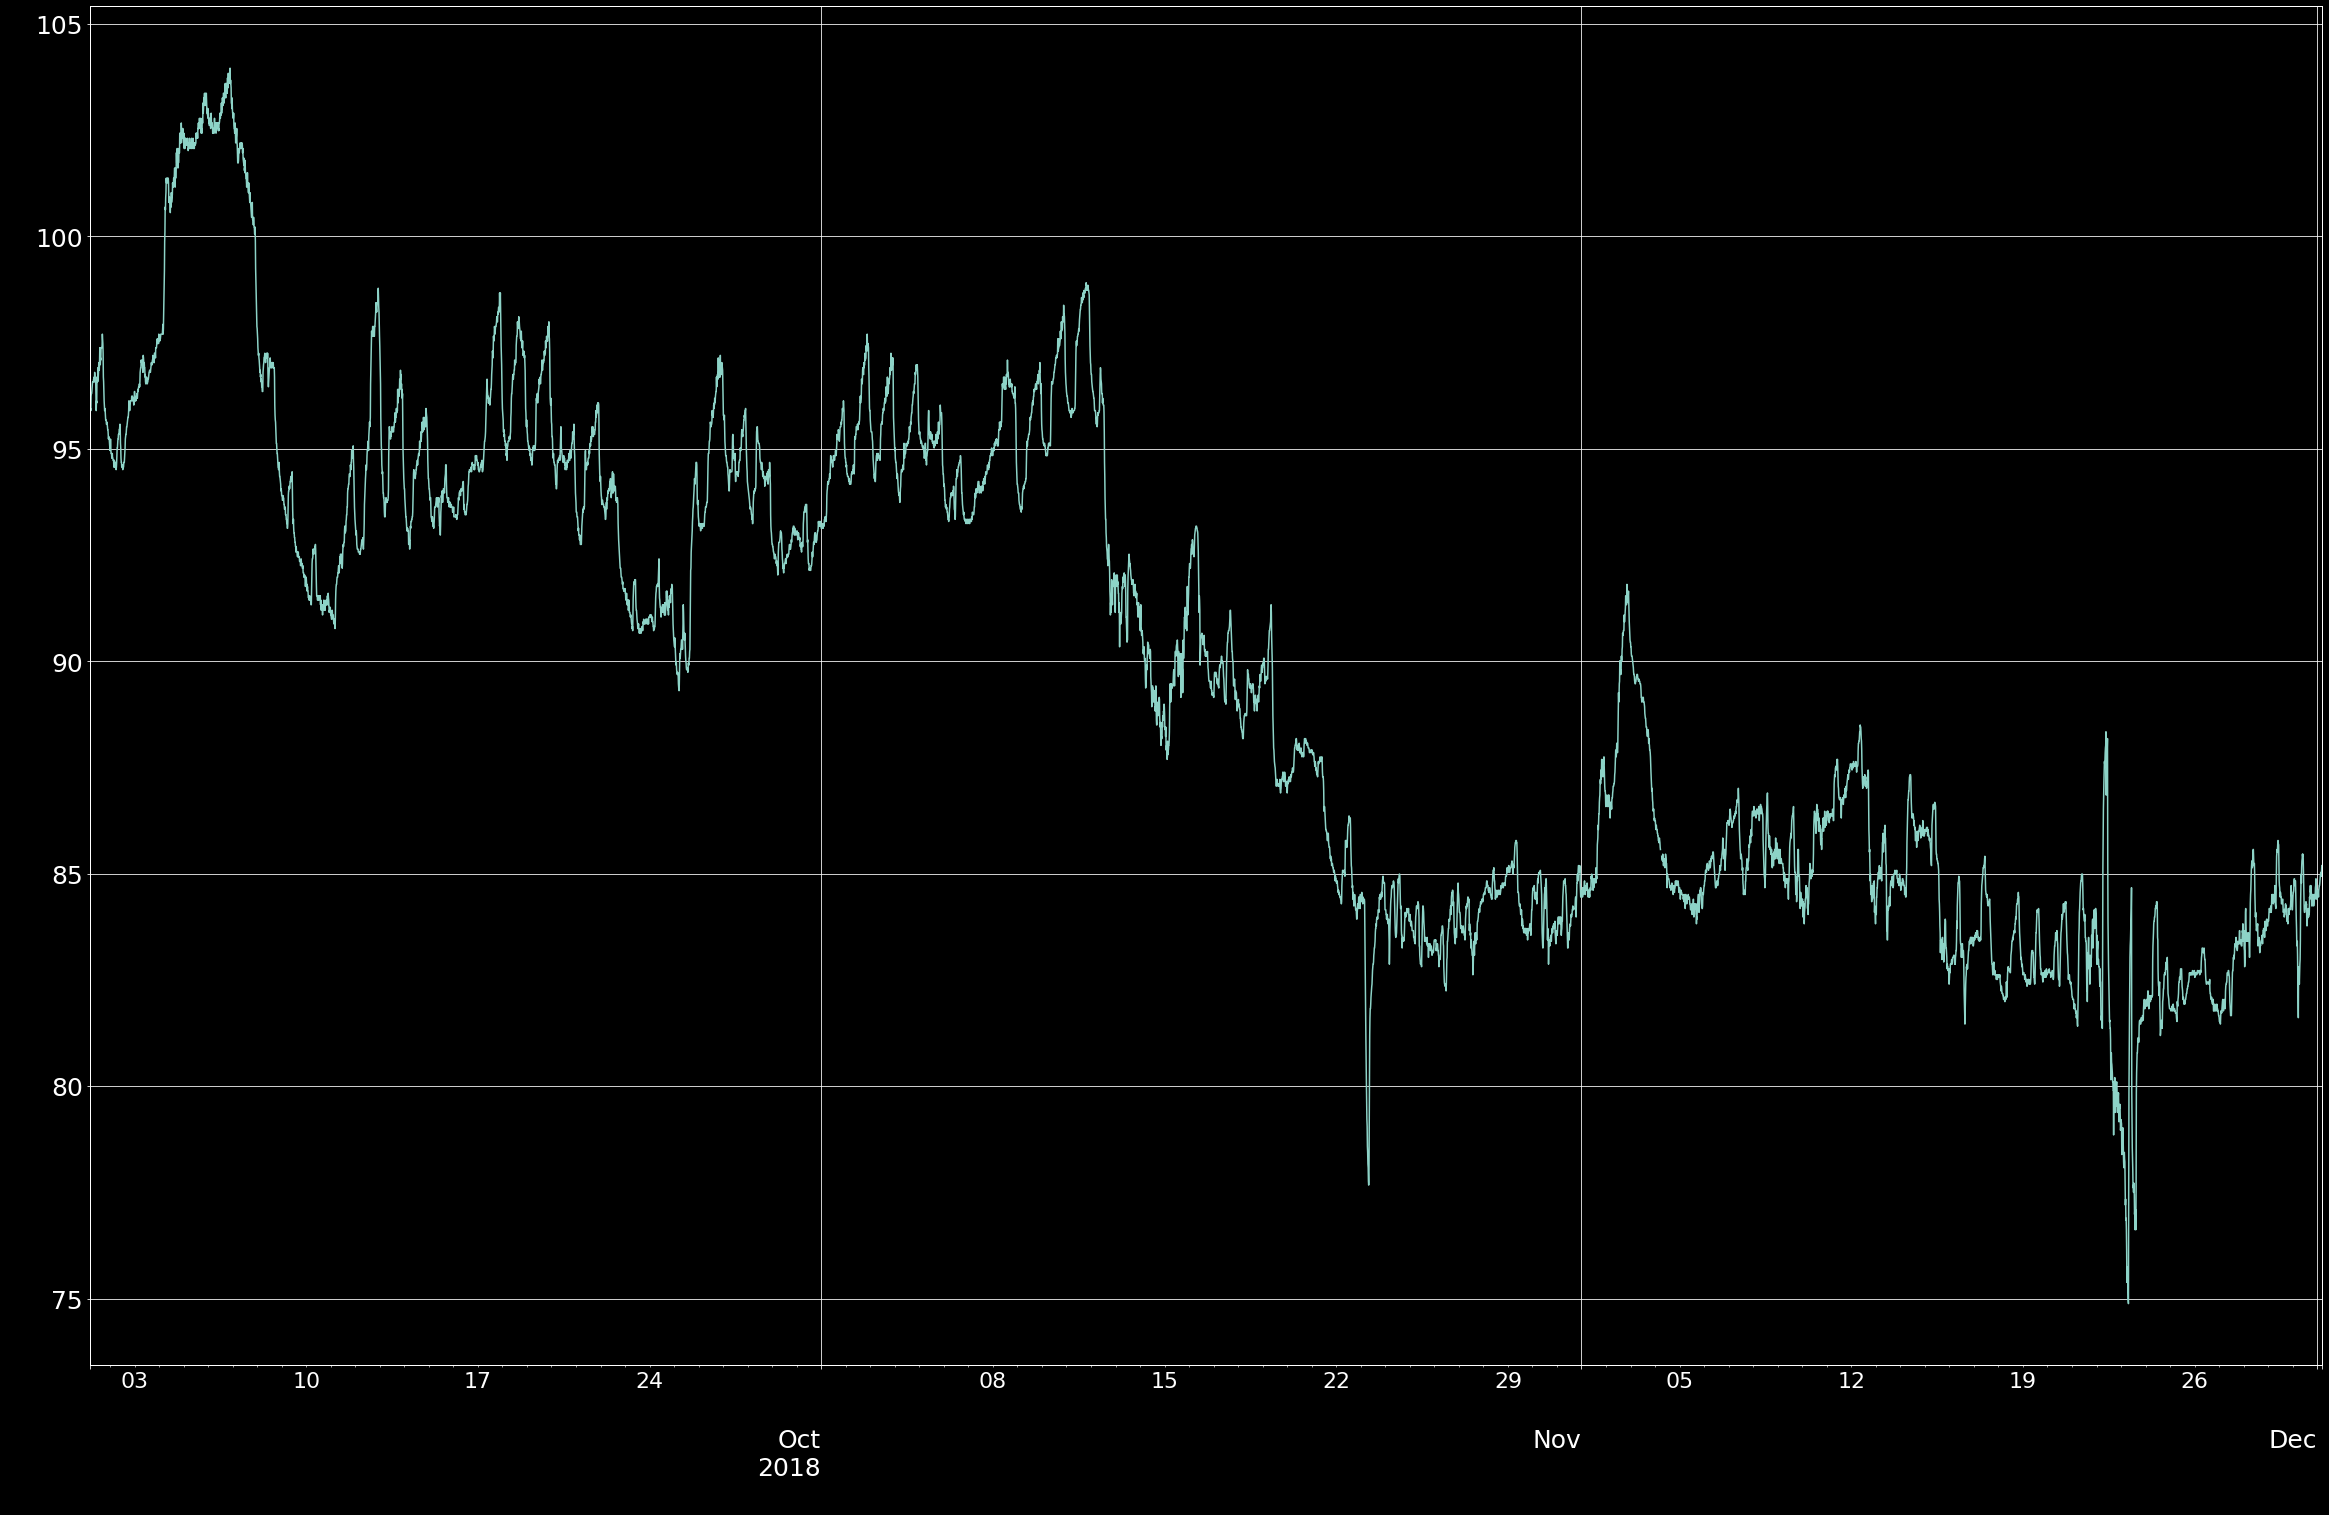

In [ ]:
plt.style.use('dark_background')

df["196684"].truncate(before= startendtimes.T["196684"].startDate , after = startendtimes.T["196684"].endDate).plot(figsize=(40,25))
plt.xlabel('Starting indoor temperature [ºC]',fontsize=25,color='black',weight='bold')
plt.ylabel('Ramp-up duration [min]', wrap=True,fontsize=25,color='black',weight='bold')
plt.xticks(rotation=0, fontsize=25,horizontalalignment="right", wrap=True)
plt.yticks(fontsize=25)

##Example 2 - Multifamily x Outside Air Temperature

Number of Buildings: 229
Number of Points: 44390
Number of Point Types: 246


Most occuring point types and their counts: 
Virtual                      7296
Zone Temperature             5210
Status                       2570
Discharge Air Flow           2522
Command                      1704
Zone Temperature Setpoint    1470
Real Power                   1298


Building types and their counts available in the dataset:
Multifamily           69
Commercial Retail     49
Commercial Office     46
Healthcare            16
Food/Beverage         13
K-12 School            9
College/University     7
Hospitality            7
Not For Profit         5
                       3
Chemicals              1
Manufacturing          1


Which type of building do you want to analyze?
Multifamily


OK
That building type represents 5834 points of the total 44390 points in the data 
Top 20 Sensor Types out of the total 72 in Multifamily buildings


Zone Temperature                               2467
Virtual      

100%|██████████| 45/45 [01:36<00:00,  2.16s/it]


What frequency do you want for recorded data?
5T


100%|██████████| 44/44 [00:12<00:00,  3.58it/s]




Data Frequency Changed to: 15T




100%|██████████| 65/65 [00:00<00:00, 68.61it/s]



Upper Bound: 115.7898349761963
Lower Bound: 7.0169417063394945



100%|██████████| 65/65 [00:01<00:00, 61.45it/s]




********Problematic Sensors:*********


    point                 reason
0  221835          Outlying Data
1  193941  Extreme Constant Data
2  193945  Extreme Constant Data
3  193946  Extreme Constant Data
4  193943  Extreme Constant Data
5  193944  Extreme Constant Data
6  193942  Extreme Constant Data
7  310273  Extreme Constant Data
8  310902  Extreme Constant Data
9  380110  Extreme Constant Data


Here are some of the Porblematic Sensors' Plots:



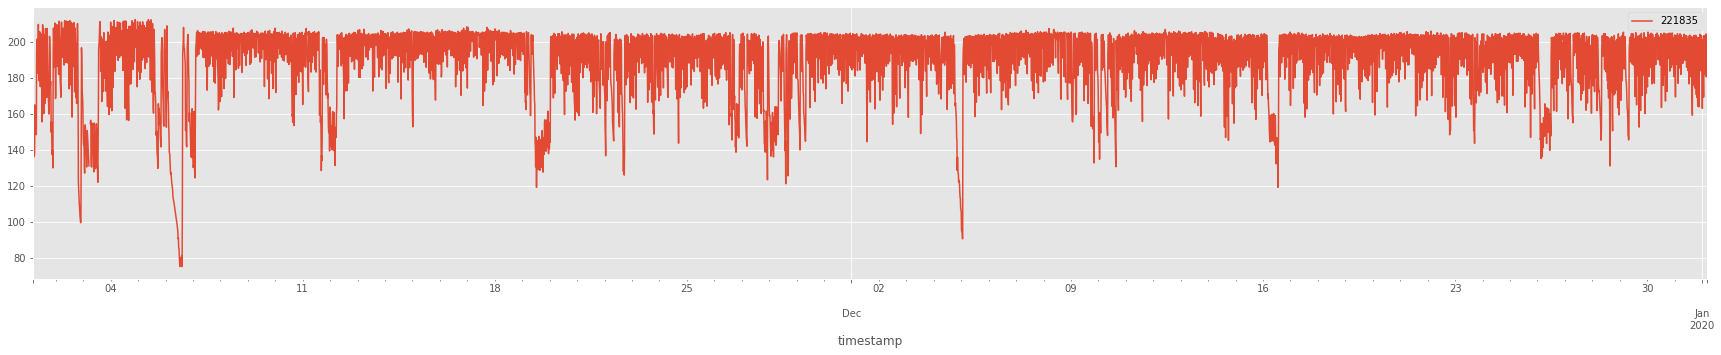

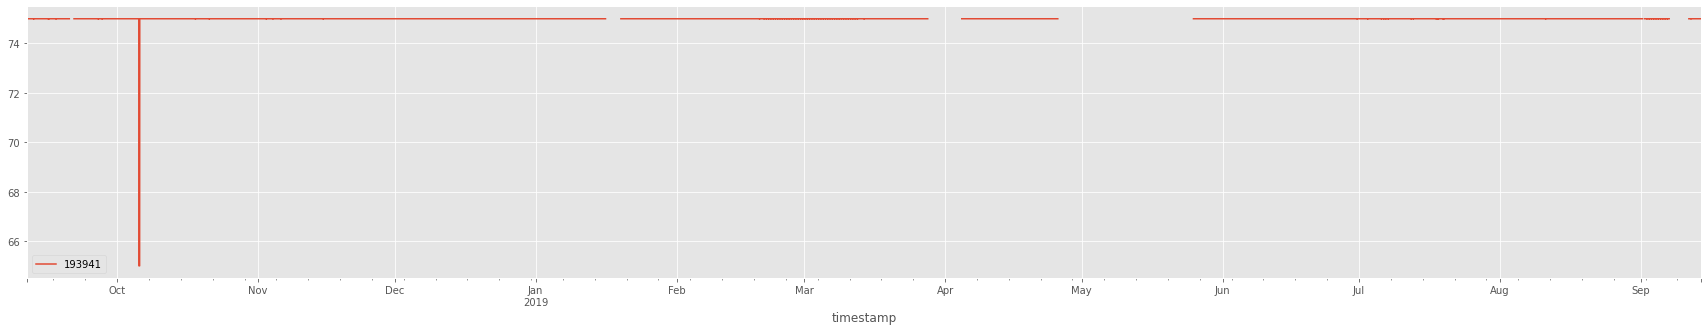

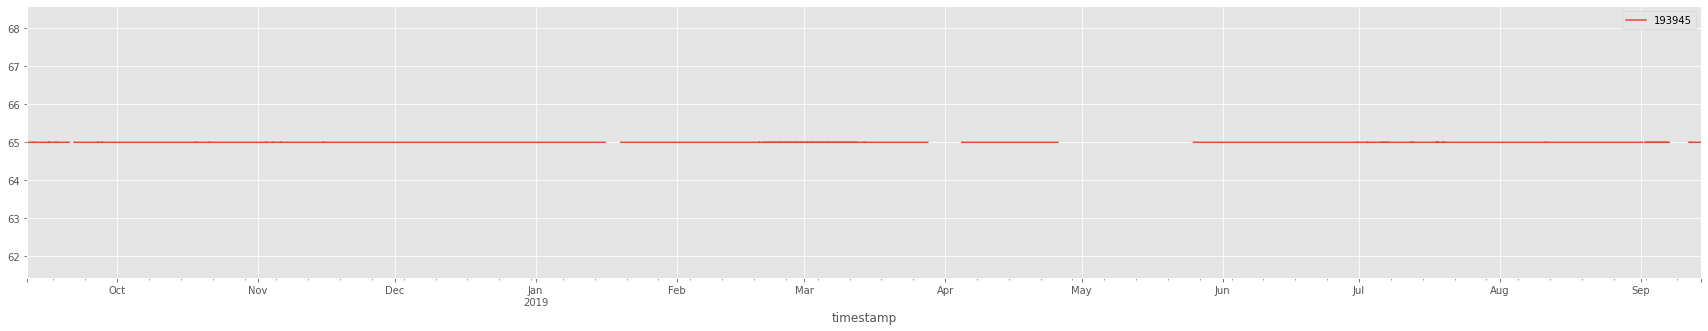

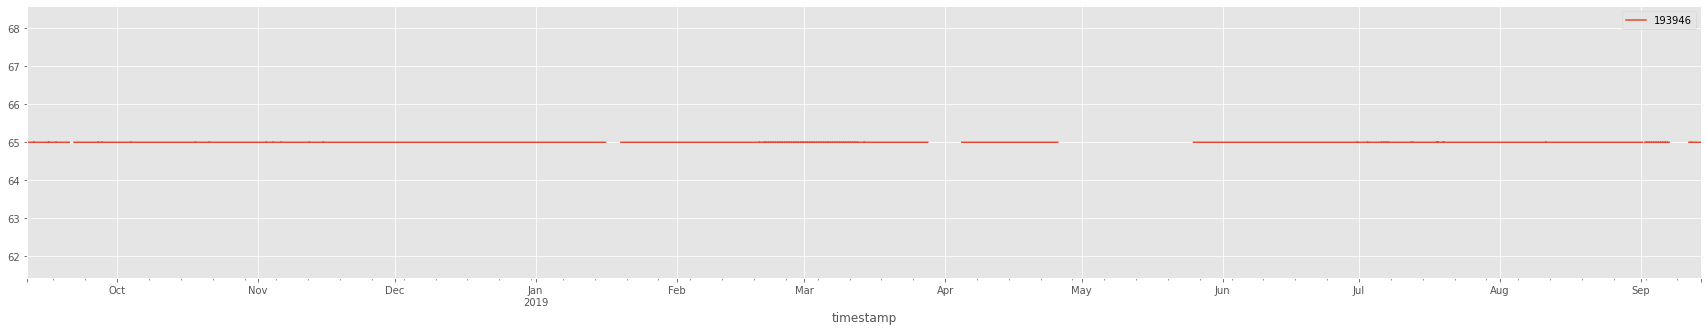

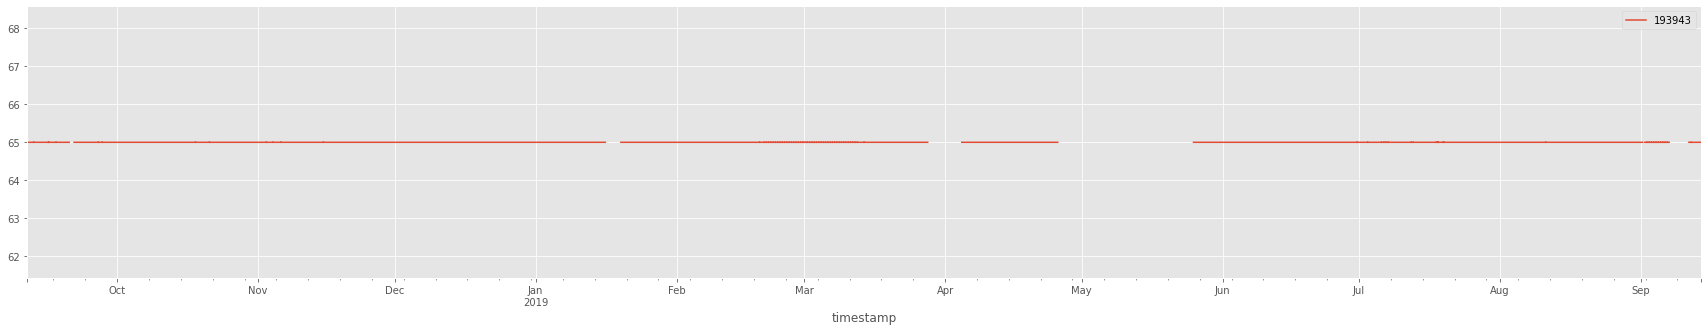

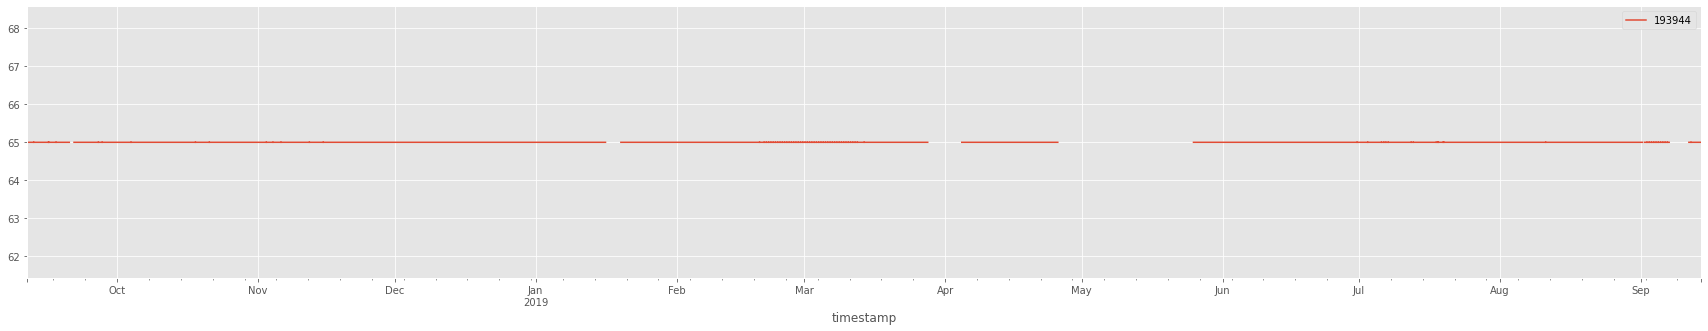

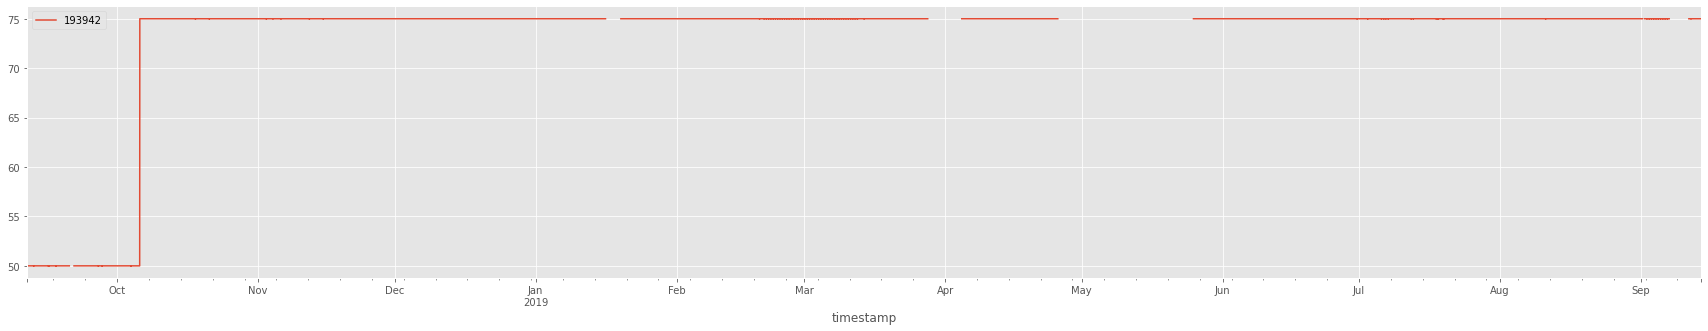

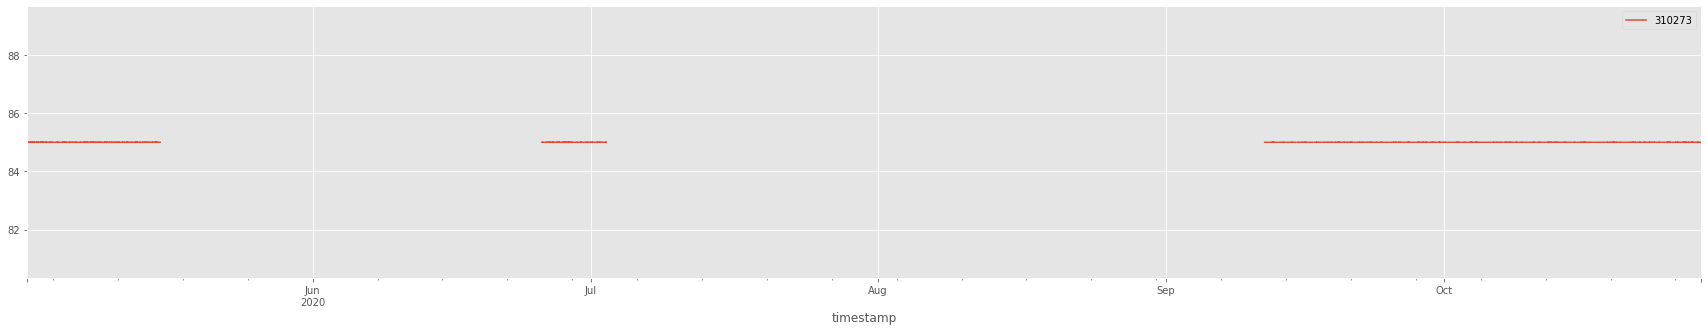

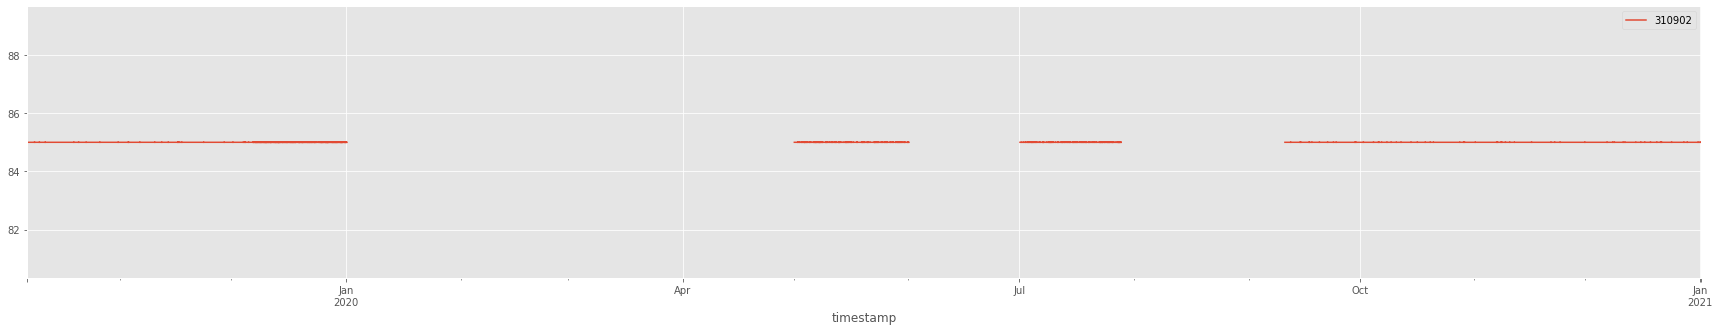

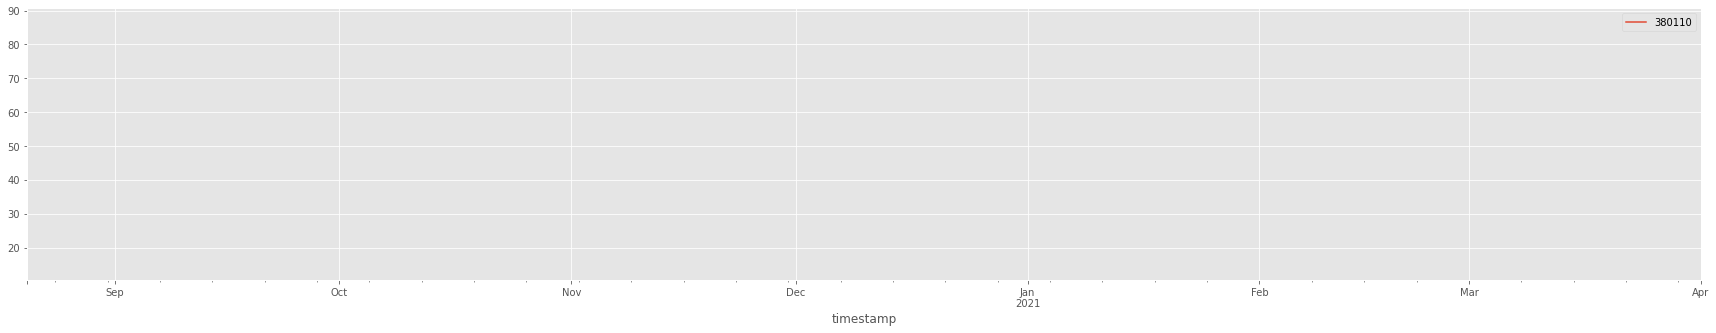

<Figure size 2160x1080 with 0 Axes>

In [ ]:
bdgs_selected = info_desk(metadata)
more_info(metadata , bdgs_selected)
dict_data , propertytype = dict_builder(metadata , bdgs_selected)
df , startendtimes = df_builder (metadata , dict_data, propertytype)
df , filtered_list = nan_detector(df, startendtimes , max_nan = 0.9)
df , constant_list = constant_detector (df , startendtimes ,max_constant = 0.9)
df , negligible_list = negligible_detector (df , startendtimes , min_days = 10)
df , outlier_list = outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5)
df.columns = df.columns.map(str)
startendtimes.index = startendtimes.index.map(str)
df_final = show_results(df , startendtimes, filtered_list , constant_list , negligible_list , outlier_list)

##Example 3 - Commercial Retail x Zone Temperature

Number of Buildings: 229
Number of Points: 44390
Number of Point Types: 246


Most occuring point types and their counts: 
Virtual                      7296
Zone Temperature             5210
Status                       2570
Discharge Air Flow           2522
Command                      1704
Zone Temperature Setpoint    1470
Real Power                   1298


Building types and their counts available in the dataset:
Multifamily           69
Commercial Retail     49
Commercial Office     46
Healthcare            16
Food/Beverage         13
K-12 School            9
College/University     7
Hospitality            7
Not For Profit         5
                       3
Chemicals              1
Manufacturing          1


Which type of building do you want to analyze?
Commercial Retail


OK
That building type represents 1625 points of the total 44390 points in the data 
Top 20 Sensor Types out of the total 51 in Commercial Retail buildings


Electric Consumption                 270
Virtual     

100%|██████████| 38/38 [01:42<00:00,  2.69s/it]


What frequency do you want for recorded data?
15T


100%|██████████| 38/38 [00:12<00:00,  2.95it/s]


100%|██████████| 180/180 [00:07<00:00, 25.64it/s]



Upper Bound: 80.5
Lower Bound: 60.5



100%|██████████| 180/180 [00:07<00:00, 24.68it/s]




********Problematic Sensors:*********


      point                reason
0    214414  Extreme Lack of Data
1    214277  Extreme Lack of Data
2    214296  Extreme Lack of Data
3    214317  Extreme Lack of Data
4    214345  Extreme Lack of Data
..      ...                   ...
197  197180      Extreme NAN Data
198  197181      Extreme NAN Data
199  197182      Extreme NAN Data
200  197183      Extreme NAN Data
201  221851      Extreme NAN Data

[202 rows x 2 columns]


Here are some of the Porblematic Sensors' Plots:



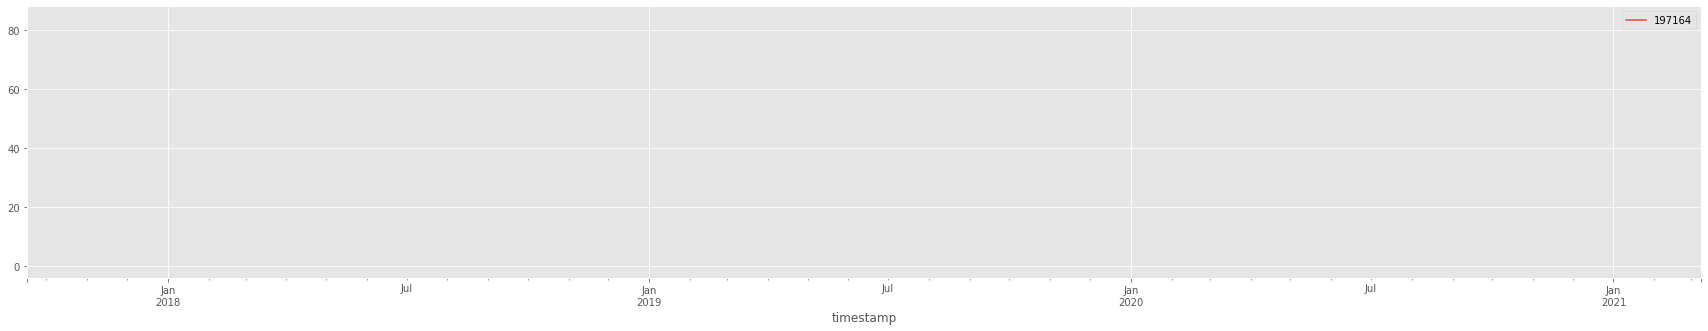

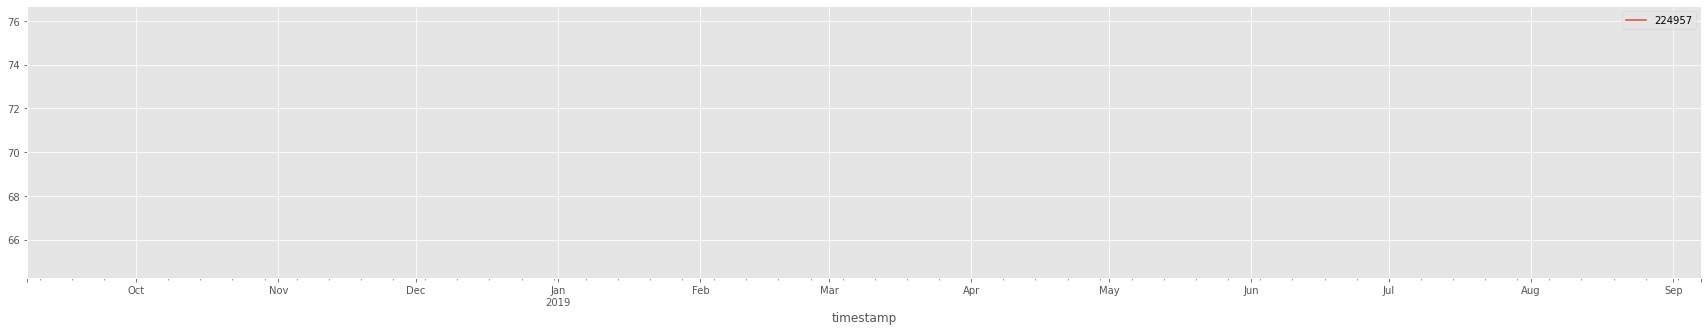

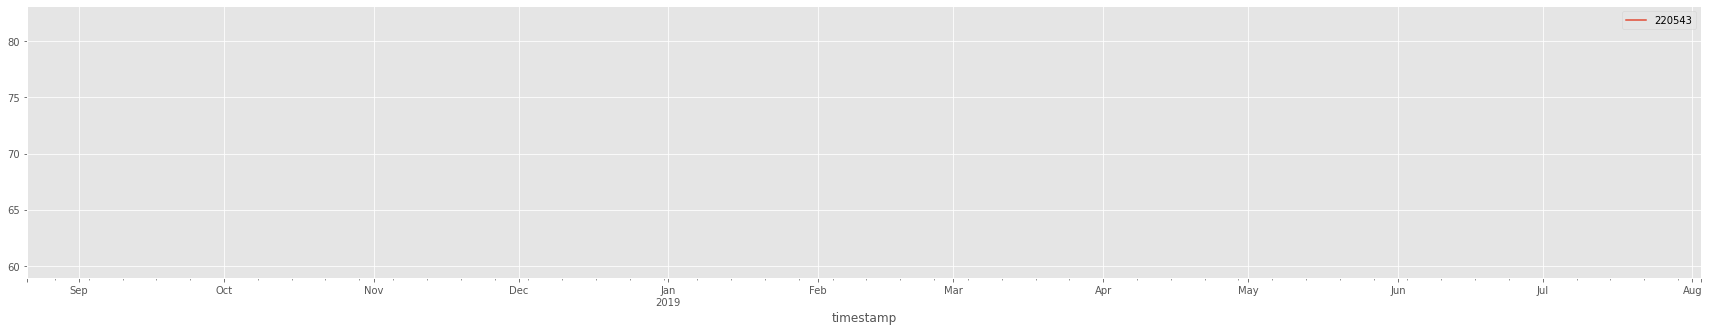

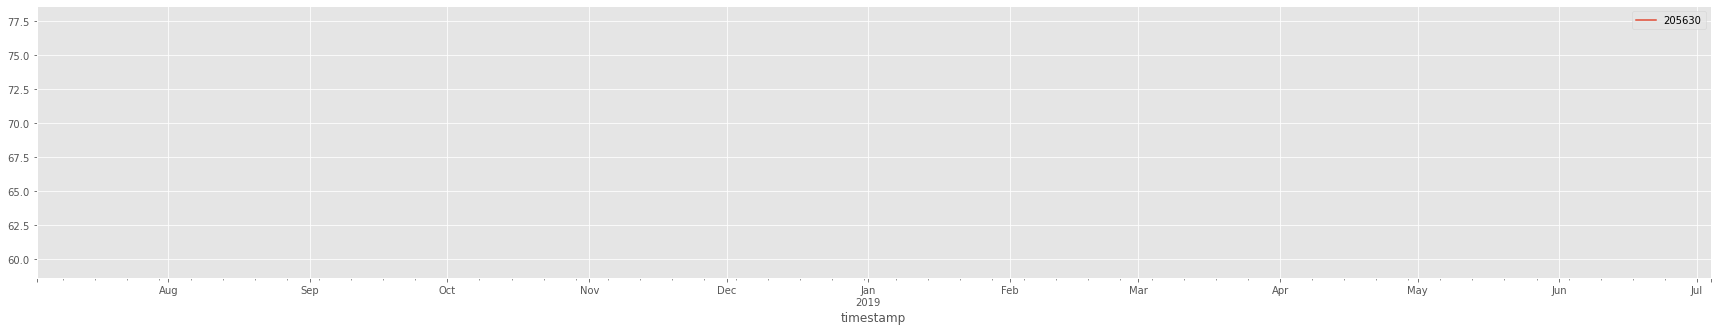

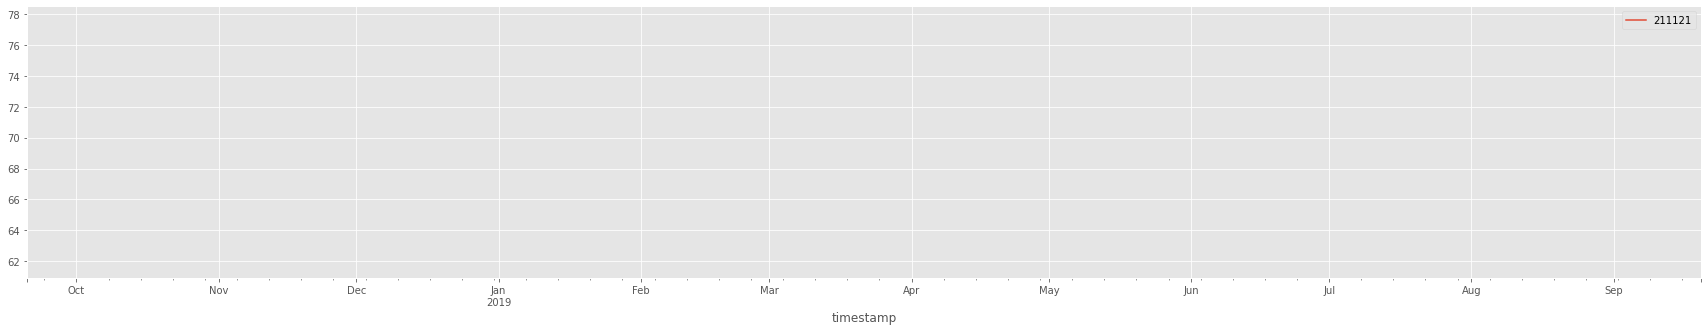

<Figure size 2160x1080 with 0 Axes>

In [ ]:
bdgs_selected = info_desk(metadata)
more_info(metadata , bdgs_selected)
dict_data , propertytype = dict_builder(metadata , bdgs_selected)
df , startendtimes = df_builder (metadata , dict_data, propertytype)
df , filtered_list = nan_detector(df, startendtimes , max_nan = 0.9)
df , constant_list = constant_detector (df , startendtimes ,max_constant = 0.9)
df , negligible_list = negligible_detector (df , startendtimes , min_days = 10)
df , outlier_list = outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5)
df.columns = df.columns.map(str)
startendtimes.index = startendtimes.index.map(str)
df_final = show_results(df , startendtimes, filtered_list , constant_list , negligible_list , outlier_list)

## Example 4 - Food/Beverage x Discharge Air Flow

Number of Buildings: 229
Number of Points: 44390
Number of Point Types: 246


Most occuring point types and their counts: 
Virtual                      7296
Zone Temperature             5210
Status                       2570
Discharge Air Flow           2522
Command                      1704
Zone Temperature Setpoint    1470
Real Power                   1298


Building types and their counts available in the dataset:
Multifamily           69
Commercial Retail     49
Commercial Office     46
Healthcare            16
Food/Beverage         13
K-12 School            9
College/University     7
Hospitality            7
Not For Profit         5
                       3
Chemicals              1
Manufacturing          1


Which type of building do you want to analyze?
Food/Beverage


OK
That building type represents 1444 points of the total 44390 points in the data 
Top 20 Sensor Types out of the total 40 in Food/Beverage buildings


Virtual                              337
Electric Consumption

100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


What frequency do you want for recorded data?
5T


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


100%|██████████| 39/39 [00:00<00:00, 132.63it/s]



Upper Bound: 0.0
Lower Bound: 0.0



100%|██████████| 39/39 [00:00<00:00, 121.58it/s]




********Problematic Sensors:*********


     point                 reason
0   220449  Extreme Constant Data
1   219677  Extreme Constant Data
2   219711  Extreme Constant Data
3   219729  Extreme Constant Data
4   219747  Extreme Constant Data
5   219765  Extreme Constant Data
6   219783  Extreme Constant Data
7   219800  Extreme Constant Data
8   219817  Extreme Constant Data
9   219835  Extreme Constant Data
10  219852  Extreme Constant Data
11  219870  Extreme Constant Data
12  219887  Extreme Constant Data
13  219905  Extreme Constant Data
14  219922  Extreme Constant Data
15  219943  Extreme Constant Data
16  219983  Extreme Constant Data
17  220005  Extreme Constant Data
18  220026  Extreme Constant Data
19  220047  Extreme Constant Data
20  220069  Extreme Constant Data
21  220090  Extreme Constant Data
22  220111  Extreme Constant Data
23  220132  Extreme Constant Data
24  220154  Extreme Constant Data
25  220176  Extreme Constant Data
26  220197  Extreme Constant Data
27  22

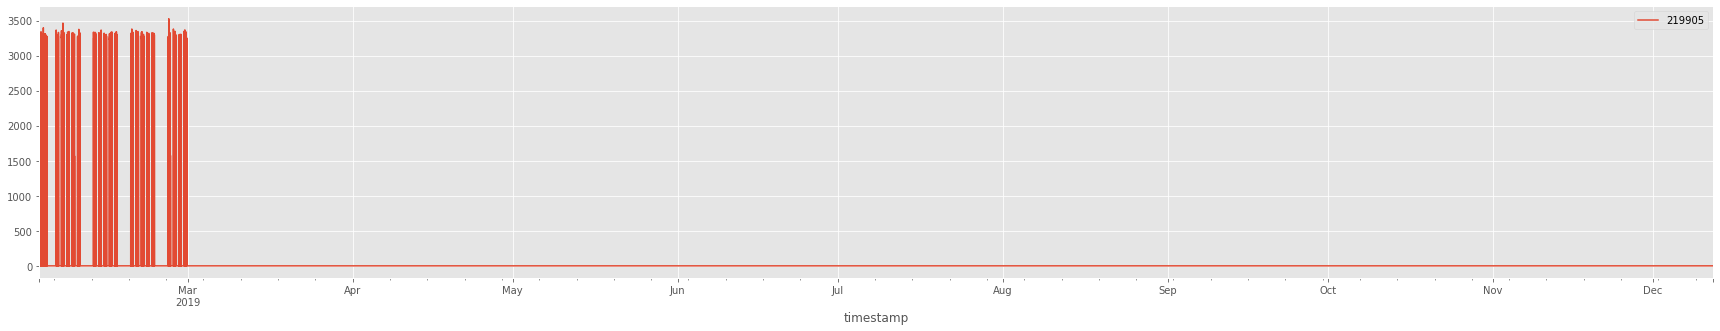

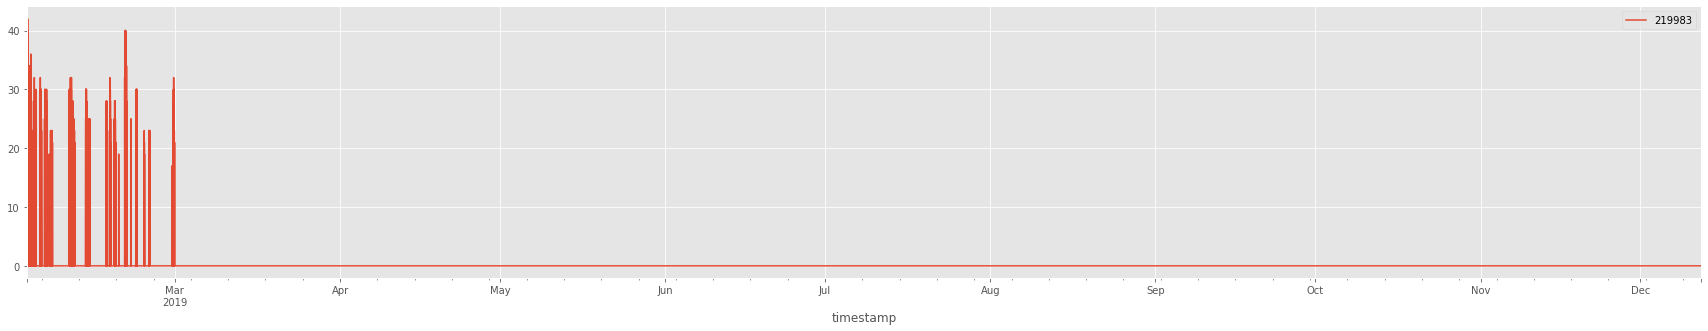

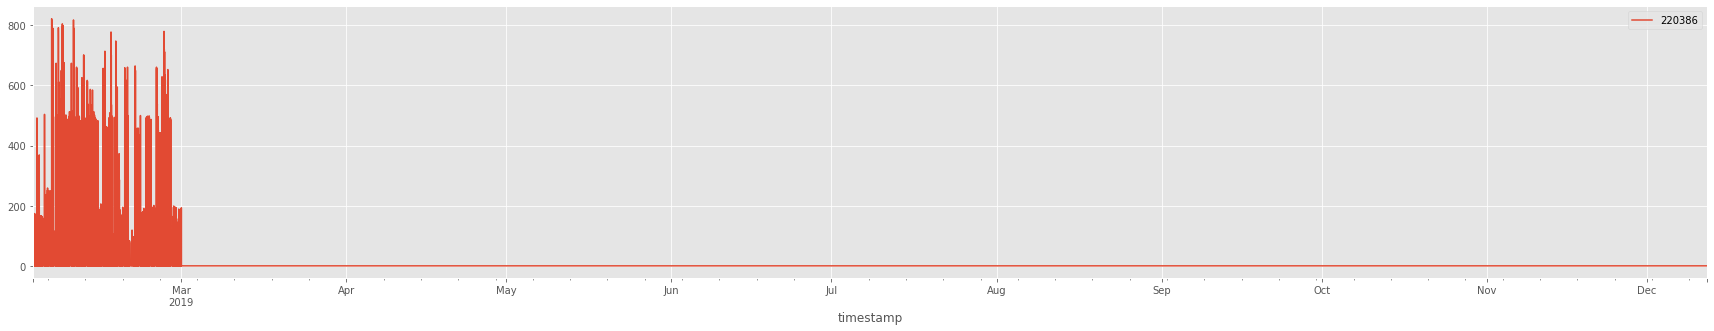

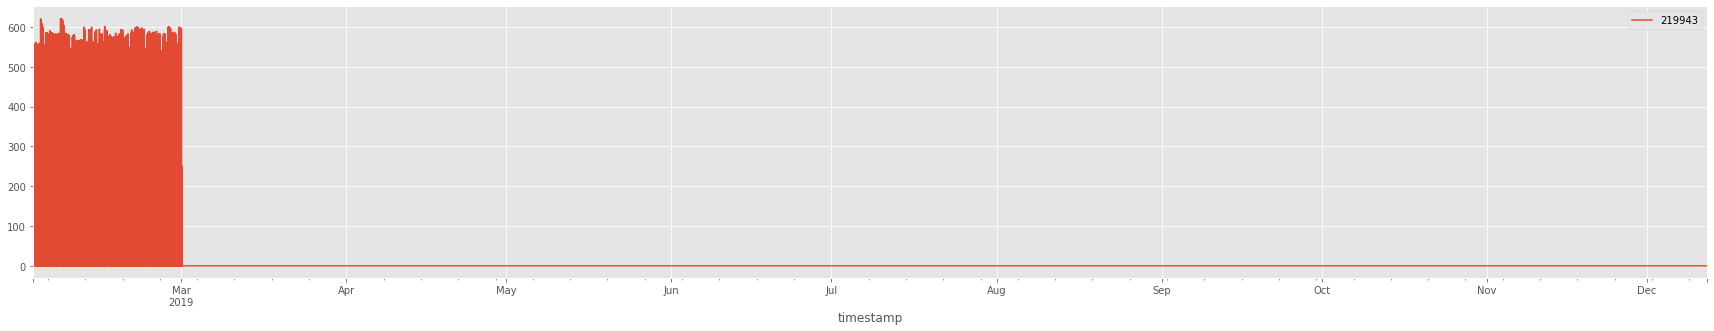

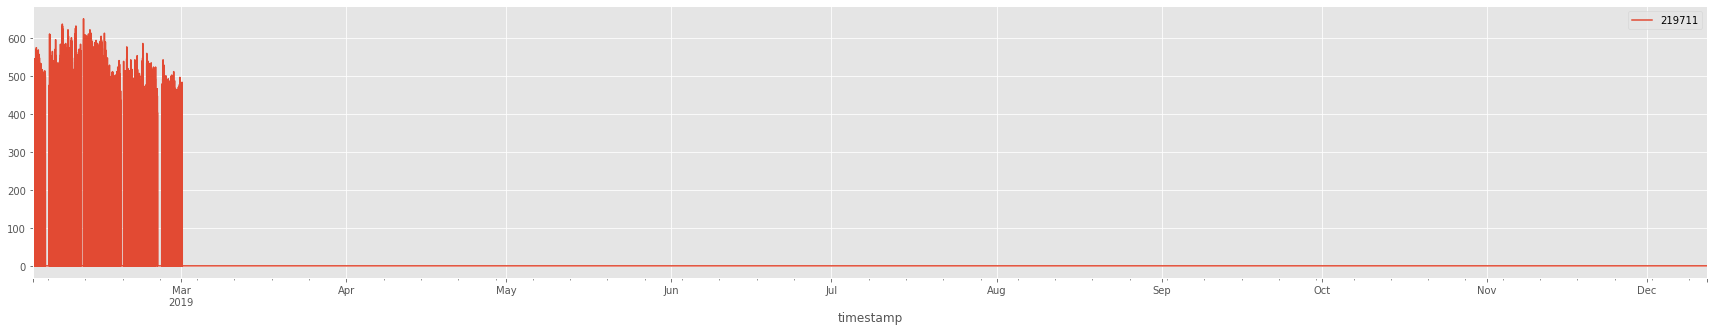

<Figure size 2160x1080 with 0 Axes>

In [76]:
bdgs_selected = info_desk(metadata)
more_info(metadata , bdgs_selected)
dict_data , propertytype = dict_builder(metadata , bdgs_selected)
df , startendtimes = df_builder (metadata , dict_data, propertytype)
df , filtered_list = nan_detector(df, startendtimes , max_nan = 0.9)
df , constant_list = constant_detector (df , startendtimes ,max_constant = 0.9)
df , negligible_list = negligible_detector (df , startendtimes , min_days = 10)
df , outlier_list = outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5)
df.columns = df.columns.map(str)
startendtimes.index = startendtimes.index.map(str)
df_final = show_results(df , startendtimes, filtered_list , constant_list , negligible_list , outlier_list)

##Example 5 - Healthcare x Return Air Temperature

In [ ]:
bdgs_selected = info_desk(metadata)
more_info(metadata , bdgs_selected)
dict_data , propertytype = dict_builder(metadata , bdgs_selected)
df , startendtimes = df_builder (metadata , dict_data, propertytype)
df , filtered_list = nan_detector(df, startendtimes , max_nan = 0.9)
df , constant_list = constant_detector (df , startendtimes ,max_constant = 0.9)
df , negligible_list = negligible_detector (df , startendtimes , min_days = 10)
df , outlier_list = outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5)
df.columns = df.columns.map(str)
startendtimes.index = startendtimes.index.map(str)
df_final = show_results(df , startendtimes, filtered_list , constant_list , negligible_list , outlier_list)

Number of Buildings: 229
Number of Points: 44390
Number of Point Types: 246


Most occuring point types and their counts: 
Virtual                      7296
Zone Temperature             5210
Status                       2570
Discharge Air Flow           2522
Command                      1704
Zone Temperature Setpoint    1470
Real Power                   1298


Building types and their counts available in the dataset:
Multifamily           69
Commercial Retail     49
Commercial Office     46
Healthcare            16
Food/Beverage         13
K-12 School            9
College/University     7
Hospitality            7
Not For Profit         5
                       3
Chemicals              1
Manufacturing          1


Which type of building do you want to analyze?
Healthcare


OK
That building type represents 8647 points of the total 44390 points in the data 
Top 20 Sensor Types out of the total 140 in Healthcare buildings


Discharge Air Flow                        2203
Virtual            

 17%|█▋        | 1/6 [00:33<02:46, 33.30s/it]


OnboardTemporaryException: ignored

## Example 6 - Healthcare x Outside Air Temperature

Number of Buildings: 229
Number of Points: 44390
Number of Point Types: 246


Most occuring point types and their counts: 
Virtual                      7296
Zone Temperature             5210
Status                       2570
Discharge Air Flow           2522
Command                      1704
Zone Temperature Setpoint    1470
Real Power                   1298


Building types and their counts available in the dataset:
Multifamily           69
Commercial Retail     49
Commercial Office     46
Healthcare            16
Food/Beverage         13
K-12 School            9
College/University     7
Hospitality            7
Not For Profit         5
                       3
Chemicals              1
Manufacturing          1


Which type of building do you want to analyze?
Healthcare


OK
That building type represents 8647 points of the total 44390 points in the data 
Top 20 Sensor Types out of the total 140 in Healthcare buildings


Discharge Air Flow                        2203
Virtual            

100%|██████████| 15/15 [03:32<00:00, 14.15s/it]


What frequency do you want for recorded data?
15T


100%|██████████| 15/15 [00:04<00:00,  3.48it/s]




Data Frequency Changed to: 30T




100%|██████████| 70/70 [00:00<00:00, 78.09it/s]



Upper Bound: 119.63700850000001
Lower Bound: -20.115005099999998



100%|██████████| 70/70 [00:00<00:00, 72.32it/s]




********Problematic Sensors:*********


    point                 reason
0  357316  Extreme Constant Data
1  344390  Extreme Constant Data
2  344390       Extreme NAN Data


Here are some of the Porblematic Sensors' Plots:



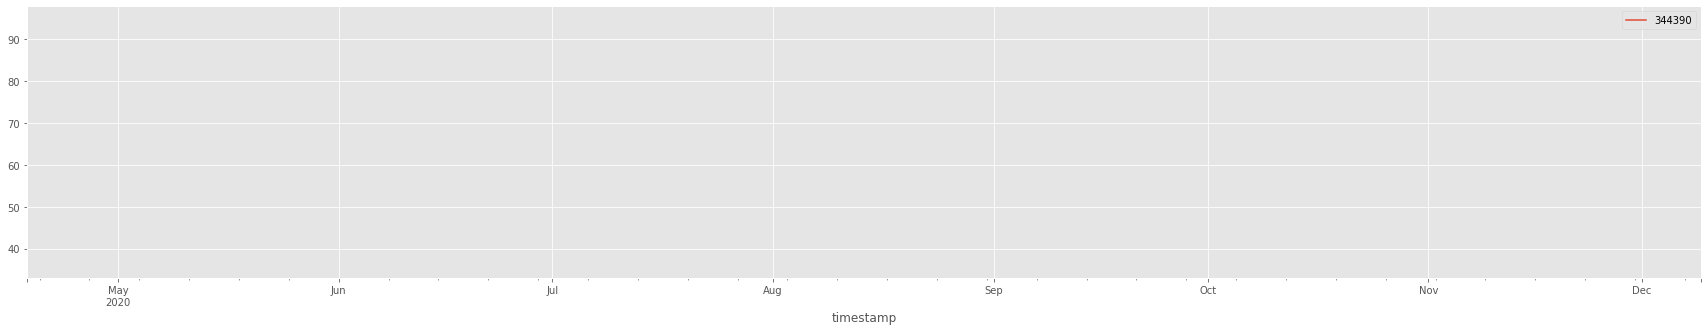

<Figure size 2160x1080 with 0 Axes>

In [ ]:
bdgs_selected = info_desk(metadata)
more_info(metadata , bdgs_selected)
dict_data , propertytype = dict_builder(metadata , bdgs_selected)
df , startendtimes = df_builder (metadata , dict_data, propertytype)
df , filtered_list = nan_detector(df, startendtimes , max_nan = 0.9)
df , constant_list = constant_detector (df , startendtimes ,max_constant = 0.9)
df , negligible_list = negligible_detector (df , startendtimes , min_days = 10)
df , outlier_list = outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5)
df.columns = df.columns.map(str)
startendtimes.index = startendtimes.index.map(str)
df_final = show_results(df , startendtimes, filtered_list , constant_list , negligible_list , outlier_list)

## Example 7 - Multifamily - Water Consumption

Number of Buildings: 229
Number of Points: 44390
Number of Point Types: 246


Most occuring point types and their counts: 
Virtual                      7296
Zone Temperature             5210
Status                       2570
Discharge Air Flow           2522
Command                      1704
Zone Temperature Setpoint    1470
Real Power                   1298


Building types and their counts available in the dataset:
Multifamily           69
Commercial Retail     49
Commercial Office     46
Healthcare            16
Food/Beverage         13
K-12 School            9
College/University     7
Hospitality            7
Not For Profit         5
                       3
Chemicals              1
Manufacturing          1


Which type of building do you want to analyze?
Multifamily


OK
That building type represents 5834 points of the total 44390 points in the data 
Top 20 Sensor Types out of the total 72 in Multifamily buildings


Zone Temperature                               2467
Virtual      

100%|██████████| 15/15 [00:20<00:00,  1.33s/it]


What frequency do you want for recorded data?
5T


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]




Data Frequency Changed to: 15T




100%|██████████| 25/25 [00:00<00:00, 182.20it/s]



Upper Bound: 0.0
Lower Bound: 0.0



100%|██████████| 25/25 [00:00<00:00, 156.40it/s]


********Problematic Sensors:*********


     point                 reason
0   386654  Extreme Constant Data
1   386655  Extreme Constant Data
2   386648  Extreme Constant Data
3   386649  Extreme Constant Data
4   386650  Extreme Constant Data
5   386651  Extreme Constant Data
6   386652  Extreme Constant Data
7   386653  Extreme Constant Data
8   344962  Extreme Constant Data
9   344963  Extreme Constant Data
10  344964  Extreme Constant Data
11  344965  Extreme Constant Data
12  344960  Extreme Constant Data
13  344961  Extreme Constant Data
14  197312  Extreme Constant Data
15  197313  Extreme Constant Data
16  197857  Extreme Constant Data
17  273941  Extreme Constant Data
18  199054  Extreme Constant Data
19  198106  Extreme Constant Data
20  201007  Extreme Constant Data
21  204554  Extreme Constant Data
22  205623  Extreme Constant Data
23  221322  Extreme Constant Data
24  227097  Extreme Constant Data


Here are some of the Porblematic Sensors' Plots:



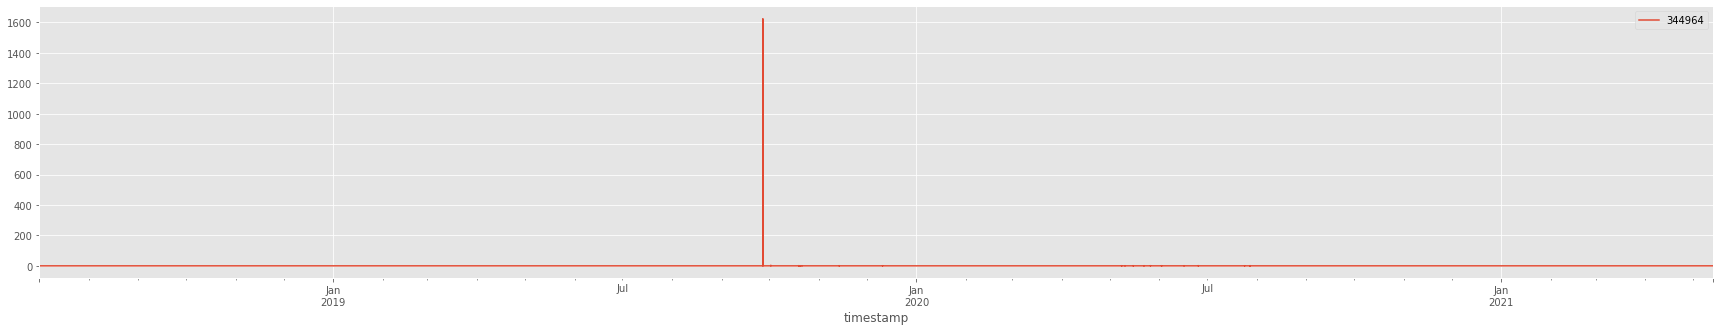

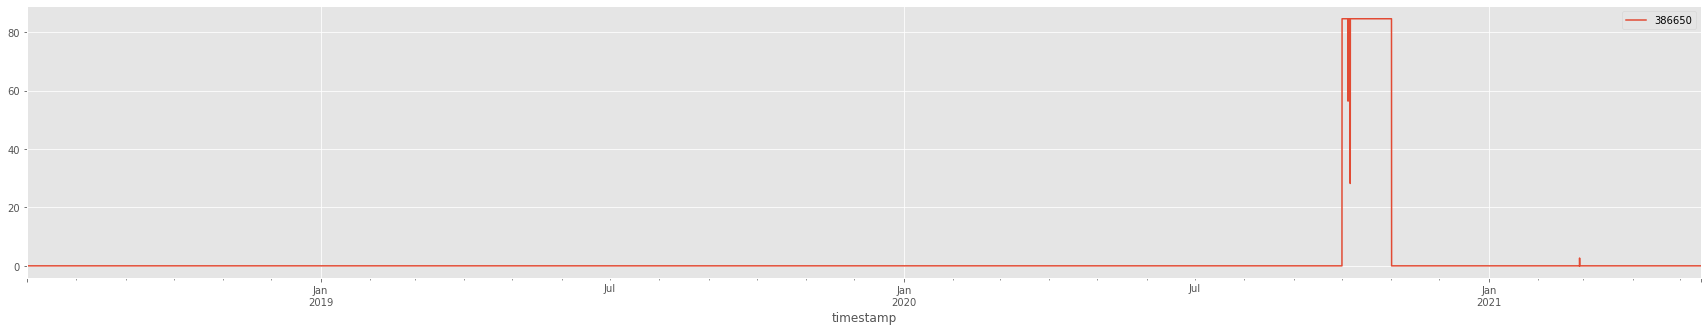

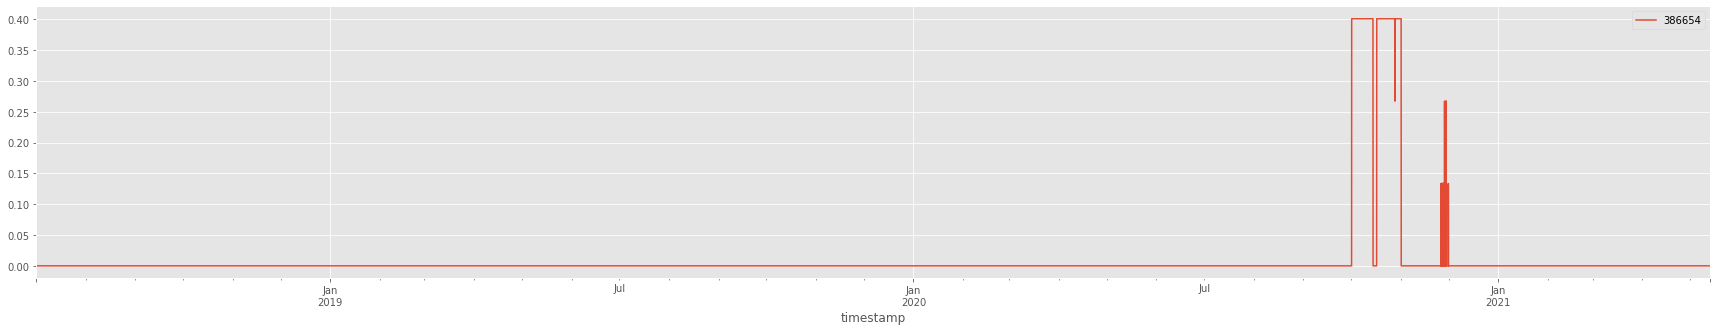

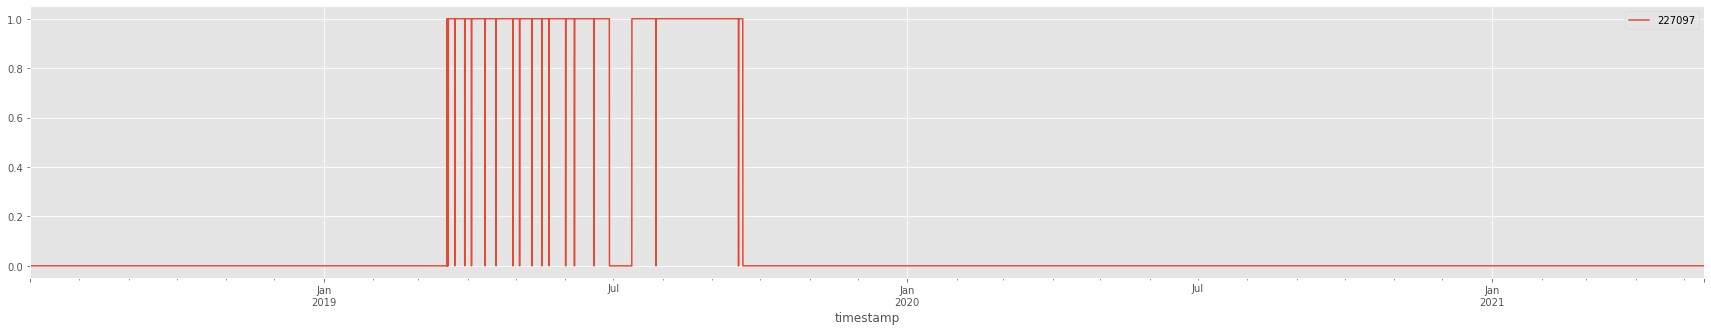

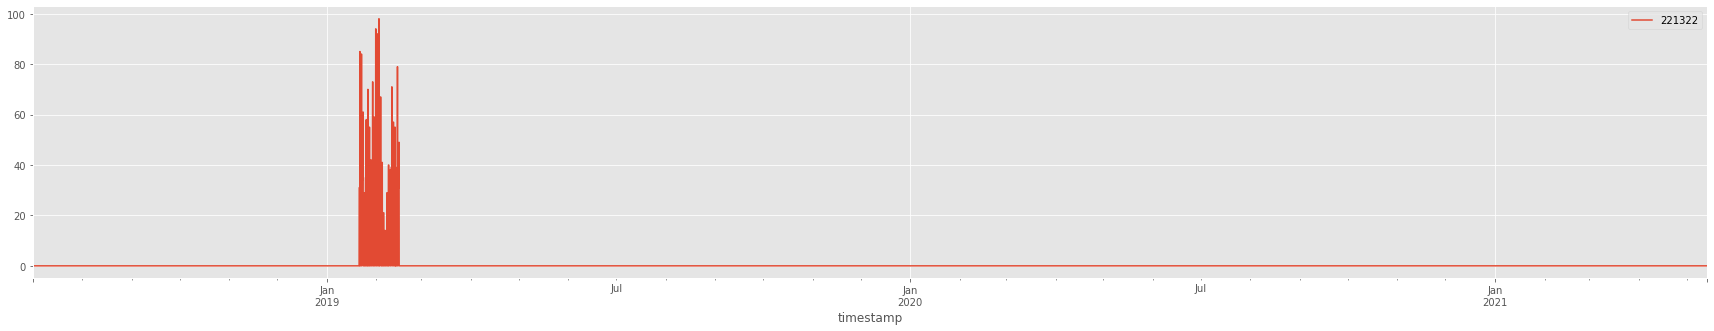

<Figure size 2160x1080 with 0 Axes>

In [74]:
bdgs_selected = info_desk(metadata)
more_info(metadata , bdgs_selected)
dict_data , propertytype = dict_builder(metadata , bdgs_selected)
df , startendtimes = df_builder (metadata , dict_data, propertytype)
df , filtered_list = nan_detector(df, startendtimes , max_nan = 0.9)
df , constant_list = constant_detector (df , startendtimes ,max_constant = 0.9)
df , negligible_list = negligible_detector (df , startendtimes , min_days = 10)
df , outlier_list = outlier_detector(df , startendtimes , min_outlier = 0.5 , upr_parameter = 1.5 , lwr_parameter = 1.5)
df.columns = df.columns.map(str)
startendtimes.index = startendtimes.index.map(str)
df_final = show_results(df , startendtimes, filtered_list , constant_list , negligible_list , outlier_list)